In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import datetime

In [3]:
#road class conversion of CYCLANDS 1st_Road_Class variable
road_classes = np.array(['','M','A(M)','A','B','C','U'])

##upper left, lower right corners of Greater London (lat,long)

#Dan's
corners = [(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]

#Greg's
#corners = [(51.543,-0.179),(51.475,0.023)]

In [4]:
#collision data from CYCLANDS
collisions = pd.read_csv('./uk_gov/cycling_safety_uk_gov.csv',parse_dates=['Date'])
collisions['Road_name'] = road_classes[collisions['1st_Road_Class'].values].astype(object)+collisions['1st_Road_Number'].apply(str).values

#annual average daily flow traffic data from https://roadtraffic.dft.gov.uk
aadf = pd.read_csv('./uk_gov/dft_traffic_counts_aadf.csv',low_memory=False,parse_dates=['Year'])

In [5]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    #count collisions in London
    london_col += len(collisions_year)
    
    #Create Road name variable that matches aadf
    #collisions_year['Road_name'] = road_classes[collisions_year['1st_Road_Class'].values].astype(object)+collisions_year['1st_Road_Number'].apply(str).values
    
    #find nearest aadf cp neighbor to collisions
    #A is distance to nearestneighbor for each collision
    #B is index of nearestneighbor in aadf_year for each collision
    neigh = NearestNeighbors(n_neighbors=1,radius=0.1)
    neigh.fit(aadf_year[['Longitude','Latitude']])
    A,B = neigh.kneighbors(collisions_year[['Longitude','Latitude']],1)
    
    #count correct geomatches by checking Road name match
    matches += np.sum(aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values)
    
    A_match = A[aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values]
    
    print(year)
    print('mean distance to CP:',A_match.mean()*61.8)
    print('median distance to CP:',np.median(A_match)*61.8)
    print('max distance to CP:',A_match.max()*61.8)
    print('min distance to CP:',A_match.min()*61.8)
    print('Correct geo match:',len(A_match))
    print('Total London collisions:',len(collisions_year))
    print()

print('Correct geo match:',matches)
print('Total London collisions:',london_col)

2005
mean distance to CP: 0.14741646667184705
median distance to CP: 0.10272993964802504
max distance to CP: 1.6454282663225908
min distance to CP: 0.0025005235440245023
Correct geo match: 1258
Total London collisions: 3323

2006
mean distance to CP: 0.14343707807602277
median distance to CP: 0.09624101498600433
max distance to CP: 1.6781213109960773
min distance to CP: 0.0025709668155781402
Correct geo match: 1317
Total London collisions: 3387

2007
mean distance to CP: 0.14531649532298974
median distance to CP: 0.1068397281021527
max distance to CP: 1.208518823222253
min distance to CP: 0.0008388965305746833
Correct geo match: 1364
Total London collisions: 3393

2008
mean distance to CP: 0.1266115643798922
median distance to CP: 0.08571358826645212
max distance to CP: 1.0362929784596024
min distance to CP: 0.0023653730117970434
Correct geo match: 1426
Total London collisions: 3643

2009
mean distance to CP: 0.1360159964130617
median distance to CP: 0.09854121723629154
max distance to

Text(0.5, 1.0, '2018')

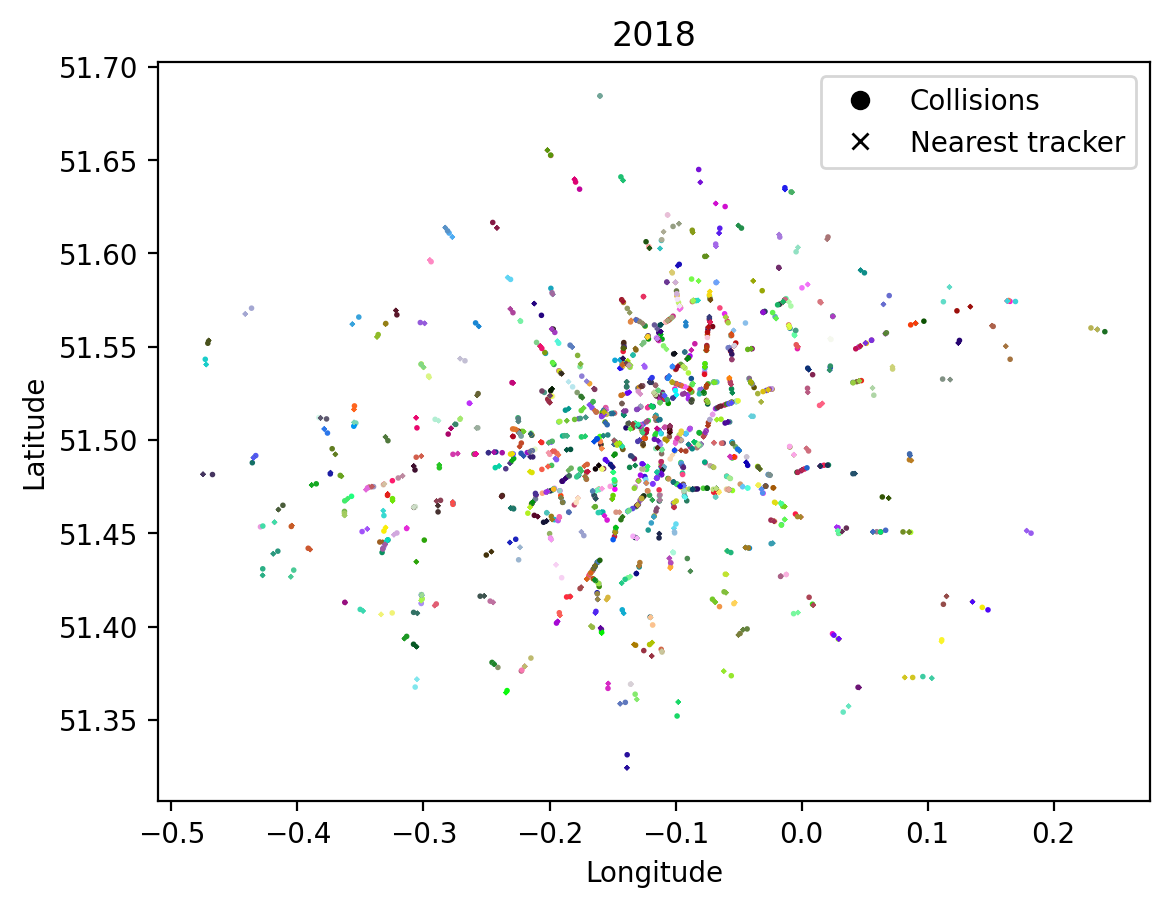

In [6]:
#here I take the A and B from above code box to plot correct matched nearest neighbors and collisions 

#how many points to plot
plotN = 1000

colors = np.random.rand(plotN,3)

#find correct matches
match_mask = aadf_year.iloc[B.flatten().tolist()].Road_name.values == collisions_year.Road_name.values

fig = plt.figure(dpi=200)
ax = fig.add_subplot(1,1,1)

#plot collisions
ax.scatter(collisions_year.iloc[match_mask].head(plotN).Longitude,collisions_year.iloc[match_mask].head(plotN).Latitude,c=colors,s=1)

#plto nearest neighbors
ax.scatter(aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[match_mask][:plotN].flatten().tolist()].Latitude.values,c=colors,marker='x',s=1)

#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='x',linestyle='')

#Create legend from custom artist/label lists
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker'])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim([-0.8,0.5])
#plt.ylim([51.2,51.8])
plt.title('2018')